# Raport z procesu budowy modelu

## 1. Cel projektu

Celem projektu było sprawdzenie, czy da się przewidywać, które rezerwacje będą
długie (co najmniej 7 nocy), oraz które cechy ofert są z tym związane w sposób
na tyle czytelny, żeby konsultanci mogli dawać właścicielom praktyczne
rekomendacje.

Zadanie modelowe: klasyfikacja binarna.

- `y = 1` – rezerwacja długa ($\geq 7$ nocy)
- `y = 0` – rezerwacja krótka ($<7$ nocy)

## 2. Jakie dane wykorzystaliśmy

Do budowy zbioru treningowego wybraliśmy takie dane, które spełniają dwa
warunki:

1. da się je powiązać z konkretną rezerwacją,
1. wynik modelu można przełożyć na rekomendacje dotyczące oferty (co właściciel
   może zmienić).

W praktyce oznaczało to wykorzystanie głównie:

- informacji o rezerwacji (daty, długość pobytu) do zbudowania targetu,
- cech oferty z `listings.csv`, które opisują standard i warunki pobytu,
- udogodnień (amenities), ponieważ są bezpośrednio „wdrażalne”.

### 2.1 Dane rezerwacji (podstawa do targetu)

Target `long_stay` został zbudowany na podstawie różnicy pomiędzy datą
rozpoczęcia a datą zakończenia pobytu. Dzięki temu target wynika bezpośrednio z
danych rezerwacyjnych, a nie z ręcznych etykiet.

Dodatkowo policzono długość pobytu w nocach i odrzucono ewidentnie błędne
przypadki (np. 0 nocy lub bardzo długie pobyty, które wyglądały na artefakty w
danych).

### 2.2 Dane ofert (cechy obiektu i hosta)

Z `listings.csv` wybrano cechy, które opisują ofertę w sposób zrozumiały i
potencjalnie istotny dla dłuższego pobytu, np.:

- parametry przestrzeni i pojemności: `accommodates`, `bedrooms`, `beds`,
  `bathrooms`,
- typ oferty: `room_type`,
- ograniczenia rezerwacji: `minimum_nights`, `maximum_nights` oraz pochodne,
- wybrane cechy hosta i sygnały jakości: `host_response_time`,
  `host_is_superhost`, `number_of_reviews`, `review_scores_*`.

Założenie: dłuższy pobyt zwykle wymaga „funkcjonalności mieszkania” (kuchnia,
pralka, przestrzeń, prywatność) oraz stabilnych warunków (jasne zasady pobytu,
przewidywalność hosta).

### 2.3 Udogodnienia (amenities)

Udogodnienia zostały potraktowane jako ważna część modelu z dwóch powodów:

- są mocno powiązane z komfortem dłuższego pobytu,
- konsultant może je łatwo przełożyć na rekomendację dla właściciela.

Aby w praktyce użyć `amenities` w modelu, zrobiono dwie rzeczy:

- policzono `amenities_count` jako ogólną miarę „bogactwa wyposażenia”,
- wybrano najczęstsze udogodnienia i zakodowano je jako cechy 0/1 (np.
  `amen_kitchen`, `amen_washer`, `amen_wifi`).

## 3. Jakie dane zostały wykluczone i dlaczego

W trakcie pracy celowo wykluczono część potencjalnych cech. Powody były głównie
dwa: wiarygodność czasowa danych oraz praktyczna użyteczność dla rekomendacji.

### 3.1 Wykluczenie `price`

`price` pochodzi z `listings.csv`, natomiast dane rezerwacji obejmują wiele lat.
`listings.csv` jest snapshotem ofert z jednego okresu, więc cena z tego pliku
nie musi odpowiadać cenie obowiązującej w momencie konkretnej rezerwacji.

To jest nie tylko problem „szumu”, ale może też prowadzić do wycieku czasowego.
Jeżeli snapshot ofert został zebrany później niż część rezerwacji, to `price`
może odzwierciedlać stan rynku i decyzje hostów z przyszłości (np. po wzroście
popytu lub po zmianach strategii), których nie było w momencie rezerwacji. W
takim przypadku model uczy się sygnału dostępnego dopiero po czasie.

Z tego powodu `price` został wykluczony z cech wejściowych.

### 3.2 Dane personalne użytkownika

Z `users.csv` nie używano danych osobowych (imię, nazwisko, dokładny adres). Nie
są potrzebne do rozwiązania problemu, a dodatkowo nie wspierają celu projektu,
którym są rekomendacje dla właścicieli.

### 3.3 Teksty recenzji z `reviews.csv`

Teksty recenzji powstają po pobycie, więc używanie ich w modelu do przewidywania
długości pobytu mogłoby prowadzić do „przecieku informacji” (model widziałby
sygnały, których nie ma w momencie decyzji o rezerwacji).

W tym etapie skupiliśmy się na cechach dostępnych „przed pobytem” i łatwych do
przełożenia na rekomendacje.

### 3.4 Cechy behawioralne

Z `sessions.csv` można budować cechy zachowania w procesie rezerwacji (np.
liczba wyświetleń, liczba kliknięć). Takie sygnały mogą być przydatne do
segmentacji lub analiz marketingowych, ale w tym projekcie priorytetem były
cechy oferty, które są bezpośrednio modyfikowalne przez właściciela.

## 4. Modele i walidacja

Zbudowano dwa modele:

- model bazowy: regresja logistyczna,
- model docelowy: XGBoost.

Regresja logistyczna daje prosty punkt odniesienia i łatwo ją interpretować.
XGBoost jest bardziej elastyczny i może uchwycić nieliniowe zależności oraz
interakcje między cechami (np. udogodnienia mogą mieć inne znaczenie w
zależności od typu oferty).

Do walidacji zastosowano podział krzyżowy z grupowaniem po `listing_id`. Celem
tego wyboru było ograniczenie sytuacji, w której ta sama oferta pojawia się
jednocześnie w zbiorze treningowym i testowym, co mogłoby sztucznie zawyżać
wyniki.

## 5. Porównanie wyników

In [1]:
%reload_ext autoreload
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "src").exists():
    p = p.parent

if not (p / "src").exists():
    raise RuntimeError('Could not find a "src" folder above the notebook working directory.')

sys.path.insert(0, str(p))

In [2]:
import warnings

import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from src.modeling.extract_features import top_logreg_features, top_xgb_shap_features
from src.modeling.train_baseline import (
    BaselineConfig,
    BaselineTrainer,
    load_dataset,
    prepare_xyg,
)
from src.utils.constants import DATA, MODEL_A_PATH, MODEL_B_PATH
from xgboost import XGBClassifier


In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer_config = BaselineConfig(do_tuning=False, print_reports=False)
    trainer = BaselineTrainer(config=trainer_config)
    df = load_dataset(DATA)

    summary = trainer.run(df)
    print("CV summary (mean±std)")
    print(summary.to_string(index=False))

### Najbardziej znaczące cechy

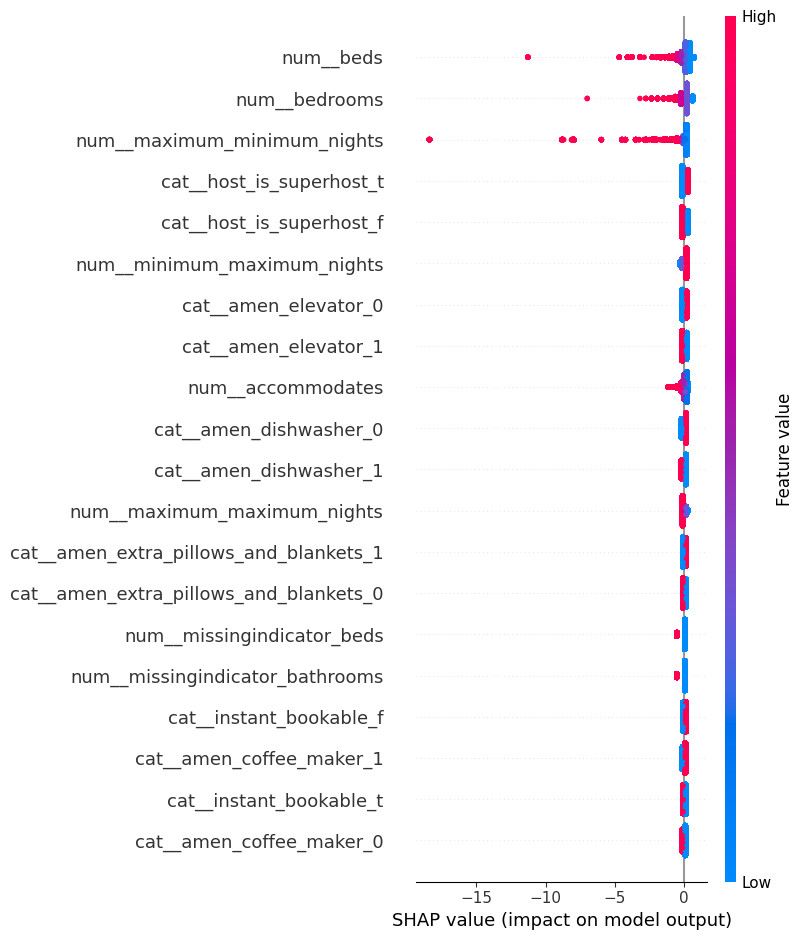

In [3]:
pipe: Pipeline = joblib.load(MODEL_A_PATH)
logreg: LogisticRegression = pipe.named_steps["clf"]

df = load_dataset(DATA)
X, _, _ = prepare_xyg(df)

prep = pipe.named_steps["prep"]
X_trans = prep.transform(X)
feature_names = prep.get_feature_names_out()

X_shap = pd.DataFrame(X_trans, columns=feature_names)
top_logreg_features(logreg, X_shap, n_features=20)


In [ ]:
pipe: Pipeline = joblib.load(MODEL_B_PATH)
xgb: XGBClassifier = pipe.named_steps["clf"]

df = load_dataset(DATA)
X, _, _ = prepare_xyg(df)

prep = pipe.named_steps["prep"]
X_trans = prep.transform(X)
feature_names = prep.get_feature_names_out()

X_shap = pd.DataFrame(X_trans, columns=feature_names)
top_xgb_shap_features(xgb, X_shap, n_features=20)

## 6. Podsumowanie

W modelu skupiono się na danych, które są jednocześnie wiarygodne i przydatne do
tworzenia rekomendacji dla konsultantów. Wykorzystano głównie cechy ofert oraz
udogodnienia, a wykluczono zmienne, które są trudne do poprawnego powiązania w
czasie z rezerwacjami (szczególnie `price`) oraz dane, które nie przekładają się
na działania właścicieli